# Project 3 - Applying CNN

#### Part 1 - Dataset Development

In [223]:
# =====================[ Import Packages ]===================== #

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [224]:
# =====================[ Load Dataset ]===================== #

class RazorbackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Folder paths
        official_dir = os.path.join(root_dir, 'official_logo')
        not_official_dir = os.path.join(root_dir, 'not_official')

        # Load official logo images (label = 1)
        for img_file in os.listdir(official_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(official_dir, img_file))
                self.labels.append(1)

        # Load non-official images (label = 0)
        for img_file in os.listdir(not_official_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(not_official_dir, img_file))
                self.labels.append(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [225]:
# Pre-Process Dataset w Transformations

# Transformations (resize to 500x500 REQUIRED)
data_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = RazorbackDataset(
    root_dir='/Users/brynnb/Repos/DASC-41103-Group-22/Project3/razorback_dataset',
    transform=data_transforms
)

# DataLoader
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Verification
print(f"Total images: {len(dataset)}")
print(f"Official logos: {sum(dataset.labels)}")
print(f"Non-official images: {len(dataset) - sum(dataset.labels)}")

Total images: 90
Official logos: 43
Non-official images: 47


#### Part 2 - CNN

**Create CNN architecture**

Going to start with a relatively simple architecture then add complexity as needed to avoid overfitting. 

Input -> Convolution 1 -> ReLu 1 -> Pooling 1 -> Convolution 2 -> ReLu 2 -> Pooling 2 -> Dropout -> Fully Connected 

In [226]:
# =====================[ Split Data into Train, Test, & Validation Sets ]===================== #

# Get all data indices and labels
all_indices = list(range(len(dataset)))
all_labels = dataset.labels # A list of 0s and 1s (43 official, 47 non-official)

# Define the split ratios
TEST_SIZE = 0.15 # 15% for the final test set
# Validation size calculation: 15% of total data is 0.15 / 0.85 ≈ 17.65% of the remaining data
VALIDATION_SIZE_RELATIVE = 0.15 / (1 - TEST_SIZE)
BATCH_SIZE = 8 # Use the batch size you prefer for training

torch.manual_seed(42)

print("--- Splitting Data (70 train/15 test/15 validate) ---")

# STEP 1: 
# Split Full Dataset into (Train + Val) and Test Sets
train_val_indices, test_indices, train_val_labels, _ = train_test_split(
    all_indices,
    all_labels,
    test_size=TEST_SIZE,     # Reserves ~15% for the Test set
    random_state=42,         # Ensures reproducibility
    stratify=all_labels      # Crucial for maintaining class balance
)

# STEP 2: 
# Split (Train + Val) Set into Train and Validation Sets
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices,
    train_val_labels,
    test_size=VALIDATION_SIZE_RELATIVE, # Reserves ~15% of the original data for Validation
    random_state=42,
    stratify=train_val_labels
)

# Create PyTorch Subset Datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# 3. Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle is True for the training set (for better generalization)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle is False for validation and test sets
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")
print(f"Total Images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")


--- Splitting Data (70 train/15 test/15 validate) ---
Train Set Size: 62
Validation Set Size: 14
Test Set Size: 14
Total Images: 90


In [227]:
# =====================[ Define CNN Architecture ]===================== #

# Input -> Convolution 1 -> ReLu 1 -> Pooling 1 -> Convolution 2 -> ReLu 2 -> Pooling 2 -> Flatten -> Dropout -> Fully Connected 

model1 = nn.Sequential()

model1.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2))
    # 1st convolution: 
    # in_channels=3 because the images are RGB not grayscale
    # out_channels=8 as a starting point
    # kernel_size=5 starting with slightly larger kernel then going smaller in the second convolution to mitigate overfitting and focus on different features
    # padding=2 for same padding (preserve dimensions)
model1.add_module('relu1', nn.ReLU())
model1.add_module('pool1', nn.MaxPool2d(kernel_size=2,stride=2)) 
    # Max pooling is more robust to noise in input data
    # kernel_size=2 and stride=2 for a 50% reduction in size (250 x 250)
model1.add_module('conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
    # 2nd convolution: 
    # in_channels=8 based on out_channels of 1st convolution
    # out_channels=16 (doubled the in_channels)
    # kernel_size=3 as mentioned above, slightly smaller to mitigate overfitting and focus on different features
    # padding=1 for same padding (preserve dimensions)
model1.add_module('relu2', nn.ReLU())
model1.add_module('pool2', nn.MaxPool2d(kernel_size=2,stride=2))
    # Max pooling is more robust to noise in input data
    # kernel_size=2 and stride=2 for a 50% reduction in size (125 x 125)

model1.add_module('flatten', nn.Flatten())
    # Flatten the output of the previous layers before the fully connected layer

model1.add_module('dropout', nn.Dropout(p=0.5))
    # Dropout layer with dropout rate 0.5 to mitigate overfitting

model1.add_module('fc', nn.Linear(250000,1))
    # Fully connected layer with 250,000 input features and size 1 output vector (binary classification)
    # FC Input Size = Conv 2 Output Channels * Final Height * Final Width
    # 250,000       = 16                     * 125          * 125

# We don’t have to specify the desired softmax activation as a final layer to obtain class-membership probabilities for each input because
# PyTorch includes the softmax calculation in the CrossEntropyLoss loss function internally for numerical stability

model1

Sequential(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=250000, out_features=1, bias=True)
)

In [228]:
# Optional: Using GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

print(f"GPU status: {torch.cuda.is_available()}")

GPU status: False


In [229]:
# =====================[ Create & Initialize Loss Function ]===================== #

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001) # using default learning rate

In [230]:
# =====================[ Create Training Function ]===================== #

def train(model, num_epochs, train_dl, valid_dl):

    # create lists to store loss and accuracy for each epoch
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        # put model in training mode so dropout will work
        model.train()

        # iterate over dataloader batches
        for x_batch, y_batch in train_dl:
            # load data to device (GPU or CPU)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass - produces z values
            pred = model(x_batch)[:, 0]

            # calculate loss
            loss = loss_fn(pred, y_batch.float())

            # backpropagate - calculate gradients but doesn't update params
            loss.backward()

            # parameter update
            optimizer.step()

            # resets gradients to 0 in preparation for next epoch (helps with convergence)
            optimizer.zero_grad()

            # add loss for this epoch to the list
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            # keep track of indexes for correct predictions
            is_correct = ((pred>=0.5).float() == y_batch).float()
            # store accuracy for the epoch using CPU
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # calculate normalized accumulation accuracy and keep track in the list
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # puts model in evaluation mode
        model.eval()

        # same steps as above with no backpropagation (don't need gradients, saving memory and compuation time)
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        # calculate same info for validation
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        # monitor changes in accuracy (and overfitting)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # return loss history and accuracy history
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [231]:
# =====================[ Train & Test ]===================== #

num_epochs = 20 # as a starting point
hist = train(model1, num_epochs, train_loader, val_loader)

/Users/brynnb/miniconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 accuracy: 0.5806 val_accuracy: 0.6429
Epoch 2 accuracy: 0.4677 val_accuracy: 0.5000
Epoch 3 accuracy: 0.5161 val_accuracy: 0.7857
Epoch 4 accuracy: 0.8226 val_accuracy: 0.7857
Epoch 5 accuracy: 0.8710 val_accuracy: 0.5000
Epoch 6 accuracy: 0.8065 val_accuracy: 0.5000
Epoch 7 accuracy: 0.7581 val_accuracy: 0.5714
Epoch 8 accuracy: 0.9032 val_accuracy: 0.6429
Epoch 9 accuracy: 1.0000 val_accuracy: 0.7857
Epoch 10 accuracy: 1.0000 val_accuracy: 0.7857
Epoch 11 accuracy: 1.0000 val_accuracy: 0.7857
Epoch 12 accuracy: 0.9839 val_accuracy: 0.6429
Epoch 13 accuracy: 0.9839 val_accuracy: 0.7143
Epoch 14 accuracy: 1.0000 val_accuracy: 0.7143
Epoch 15 accuracy: 1.0000 val_accuracy: 0.6429
Epoch 16 accuracy: 0.9839 val_accuracy: 0.7143
Epoch 17 accuracy: 0.9839 val_accuracy: 0.7143
Epoch 18 accuracy: 0.9839 val_accuracy: 0.7143
Epoch 19 accuracy: 0.9677 val_accuracy: 0.6429
Epoch 20 accuracy: 1.0000 val_accuracy: 0.6429


In [232]:
print("Loss hist train: ")
print(hist[0])
print("\nLoss hist val: ")
print(hist[1])

Loss hist train: 
[12.710164808457897, 17.779067070253433, 9.727711246859643, 7.649909388634466, 6.902535500064973, 6.732404137811353, 6.142653080724901, 5.40969640977921, 5.203396535688831, 5.266902539037889, 5.381682426698746, 5.291821787434239, 5.234255725337613, 5.1164084711382465, 5.404845520853996, 6.237613979366518, 5.319098564886278, 5.315640191878042, 5.185729703595562, 5.770613362712245]

Loss hist val: 
[11.001087461199079, 8.023240838732038, 7.84137259210859, 7.234746388026646, 7.849854673658099, 8.453700201851982, 7.38546541758946, 7.486063991274152, 7.5038315909249445, 7.441069466727121, 7.383006027766636, 7.432615177971976, 7.437861885343279, 7.410373892102923, 7.856633901596069, 7.879449674061367, 7.828140326908657, 7.800027097974505, 8.04103033883231, 8.274795055389404]


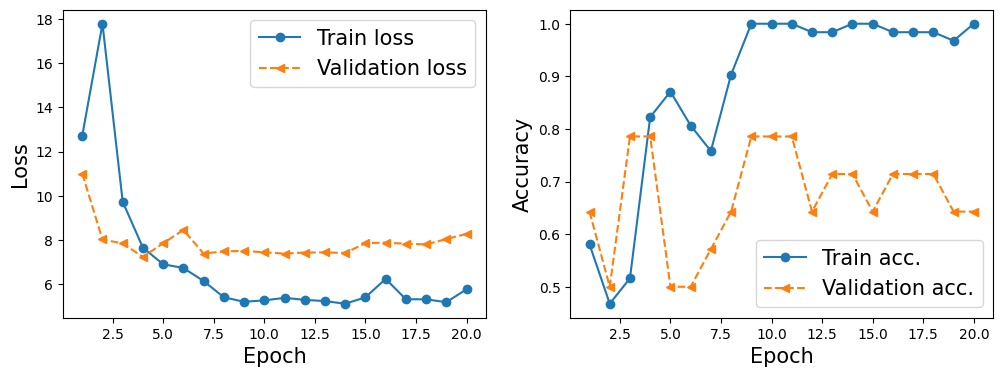

In [233]:
# =====================[ Visualize Learning Curves ]===================== #

# indexes epochs properly
x_arr = np.arange(len(hist[0])) + 1

# Plot loss over epochs
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

# Plot accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

The high training accuracy achieved early in the process, paired with the low validation accuracy, indicates the model is not generalizing well. Let's work on mitigating overfitting by simplifying the model:  

* Early stopping
* Decrease learning rate to 0.0005
* Implement weight decay of 0.005 to 0.01

In [234]:
# =====================[ Architecture & Parameter Tuning ]===================== #

# Input -> Convolution 1 -> ReLu 1 -> Pooling 1 -> Convolution 2 -> ReLu 2 -> Pooling 2 -> Flatten -> Dropout -> Fully Connected 

model2 = nn.Sequential()

model2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2))
    # 1st convolution: 
    # in_channels=3 because the images are RGB not grayscale
    # out_channels=8 as a starting point
    # kernel_size=5 starting with slightly larger kernel then going smaller in the second convolution to mitigate overfitting and focus on different features
    # padding=2 for same padding (preserve dimensions)
model2.add_module('relu1', nn.ReLU())
model2.add_module('pool1', nn.MaxPool2d(kernel_size=2,stride=2)) 
    # Max pooling is more robust to noise in input data
    # kernel_size=2 and stride=2 for a 50% reduction in size (250 x 250)
model2.add_module('conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
    # 2nd convolution: 
    # in_channels=8 based on out_channels of 1st convolution
    # out_channels=16 (doubled the in_channels)
    # kernel_size=3 as mentioned above, slightly smaller to mitigate overfitting and focus on different features
    # padding=1 for same padding (preserve dimensions)
model2.add_module('relu2', nn.ReLU())
model2.add_module('pool2', nn.MaxPool2d(kernel_size=2,stride=2))
    # Max pooling is more robust to noise in input data
    # kernel_size=2 and stride=2 for a 50% reduction in size (125 x 125)

model2.add_module('flatten', nn.Flatten())
    # Flatten the output of the previous layers before the fully connected layer

model2.add_module('dropout', nn.Dropout(p=0.5))
    # Dropout layer with dropout rate 0.5 to mitigate overfitting

model2.add_module('fc', nn.Linear(250000,1))
    # Fully connected layer with 250,000 input features and size 1 output vector (binary classification)
    # FC Input Size = Conv 2 Output Channels * Final Height * Final Width
    # 250,000       = 8                      * 125          * 125

# We don’t have to specify the desired softmax activation as a final layer to obtain class-membership probabilities for each input because
# PyTorch includes the softmax calculation in the CrossEntropyLoss loss function internally for numerical stability

model2


Sequential(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=250000, out_features=1, bias=True)
)

In [235]:
# =====================[ Create Early Stopper ]===================== #

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience             # How many epochs to wait for improvement
        self.min_delta = min_delta           # Minimum change required to count as improvement
        self.counter = 0                     # Epoch counter for patience
        self.best_validation_loss = float('inf') # Tracks the lowest loss achieved

    def early_stop(self, validation_loss):
        # 1. Check for improvement
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0 # Reset counter since loss improved
            # NOTE: You MUST save the model weights here!
        
        # 2. If loss does not improve, increment counter
        elif validation_loss >= self.best_validation_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True # Signal to stop training
        
        return False # Continue training
    

In [ ]:
# =====================[ Create Training Function w/ Early Stopping ]===================== #

def train(model, num_epochs, train_dl, valid_dl, patience):

    # Initialization (before the epoch loop)
    early_stopper = EarlyStopper(patience=5) # Set patience to 5 epochs
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    
    # create lists to store loss and accuracy for each epoch
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        # put model in training mode so dropout will work
        model.train()

        # iterate over dataloader batches
        for x_batch, y_batch in train_dl:
            # load data to device (GPU or CPU)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass - produces z values
            pred = model(x_batch)[:, 0]

            # calculate loss
            loss = loss_fn(pred, y_batch.float())

            # backpropagate - calculate gradients but doesn't update params
            loss.backward()

            # parameter update
            optimizer.step()

            # resets gradients to 0 in preparation for next epoch (helps with convergence)
            optimizer.zero_grad()

            # add loss for this epoch to the list
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            # keep track of indexes for correct predictions
            is_correct = ((pred>=0.5).float() == y_batch).float()
            # store accuracy for the epoch using CPU
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # calculate normalized accumulation accuracy and keep track in the list
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # puts model in evaluation mode
        model.eval()

        # same steps as above with no backpropagation (don't need gradients, saving memory and compuation time)
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        # calculate same info for validation
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        # Store the current validation loss in a variable
        current_val_loss = loss_hist_valid[epoch]

        # EARLY STOPPING
        if current_val_loss < best_val_loss:
            # New minimum loss found: reset counter and save the best model weights
            best_val_loss = current_val_loss
            patience_counter = 0
            
            # Save the model's weights (state_dict) when performance improves
            torch.save(model.state_dict(), 'best_model_weights.pt')
            print(f'--> Saved model at epoch {epoch+1} with Val Loss: {current_val_loss:.4f}')

        else:
            # Loss did not improve: increment counter
            patience_counter += 1
            print(f'Patience Counter: {patience_counter} of {patience}')

            if patience_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}!")
                break # Exit the epoch loop

        # monitor changes in accuracy and loss (and overfitting)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} loss_hist_valid: {loss_hist_valid[epoch]:.4f}')
        print("-" * 40)

    # Load the best model weights found during training
    try:
        model.load_state_dict(torch.load('best_model_weights.pt'))
        print("Successfully loaded best model weights.")
    except Exception as e:
        print(f"Could not load best model weights: {e}")

    # return loss history and accuracy history
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [237]:
# =====================[ Create & Initialize Loss Function ]===================== #

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005, weight_decay=0.001) 
    # decreased learning rate
    # implemented weight decay as a regularization penalty to prevent overfitting

In [238]:
# =====================[ Train & Test ]===================== #

num_epochs = 40 
hist2 = train(model2, num_epochs, train_loader, val_loader, patience=8)

--> Saved model at epoch 1 with Val Loss: 9.8883
Epoch 1 accuracy: 0.5484 val_accuracy: 0.5000
Epoch 1 loss: 8.2429 loss_hist_valid: 9.8883
----------------------------------------
--> Saved model at epoch 2 with Val Loss: 6.7956
Epoch 2 accuracy: 0.8226 val_accuracy: 0.8571
Epoch 2 loss: 7.2346 loss_hist_valid: 6.7956
----------------------------------------
--> Saved model at epoch 3 with Val Loss: 6.3592
Epoch 3 accuracy: 0.8548 val_accuracy: 0.8571
Epoch 3 loss: 7.2846 loss_hist_valid: 6.3592
----------------------------------------
Patience Counter: 1 of 8
Epoch 4 accuracy: 0.8548 val_accuracy: 0.5000
Epoch 4 loss: 6.2034 loss_hist_valid: 7.4491
----------------------------------------
Patience Counter: 2 of 8
Epoch 5 accuracy: 0.6452 val_accuracy: 0.5000
Epoch 5 loss: 5.8133 loss_hist_valid: 7.2196
----------------------------------------
Patience Counter: 3 of 8
Epoch 6 accuracy: 0.5323 val_accuracy: 0.5000
Epoch 6 loss: 5.7506 loss_hist_valid: 7.0950
---------------------------

In [ ]:
try:
    # torch.save(model, PATH) saves the entire model object (architecture + state_dict).
    torch.save(model2, 'Group_22_CNN_FullModel.ph')
    print("=" * 40)
    print(f"SUCCESS: Full model saved as Group_22_CNN_FullModel.ph")
    print("=" * 40)
except Exception as e:
    print(f"Error saving the full model: {e}")

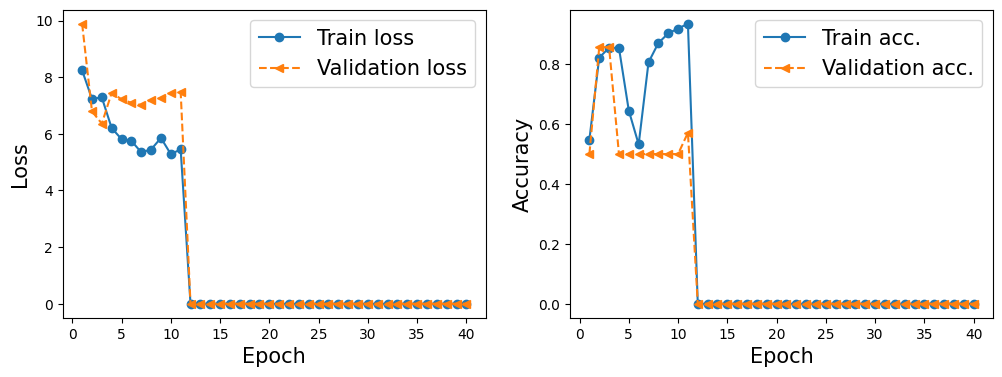

In [239]:
# =====================[ Visualize Learning Curves ]===================== #

# indexes epochs properly
x_arr = np.arange(len(hist2[0])) + 1

# Plot loss over epochs
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist2[0], '-o', label='Train loss')
ax.plot(x_arr, hist2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

# Plot accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist2[2], '-o', label='Train acc.')
ax.plot(x_arr, hist2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

Use the best model on unseen data:

In [242]:
# =====================[ Use Model on New Data ]===================== #

# Initialize counter for correct predictions
accuracy_test = 0

# Put the best model in evaluation mode
model2.eval()

# Gradients not needed
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Load data to correct device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # Forward pass
        pred = model2(x_batch)[:, 0]
        # Determine correctness
        is_correct = ((pred>=0.5).float() == y_batch).float()
        # Increment count of correct predictions
        accuracy_test += is_correct.sum().cpu()

# Calculate the final average accuracy for the test set
accuracy_test /= len(test_loader.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.6429


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


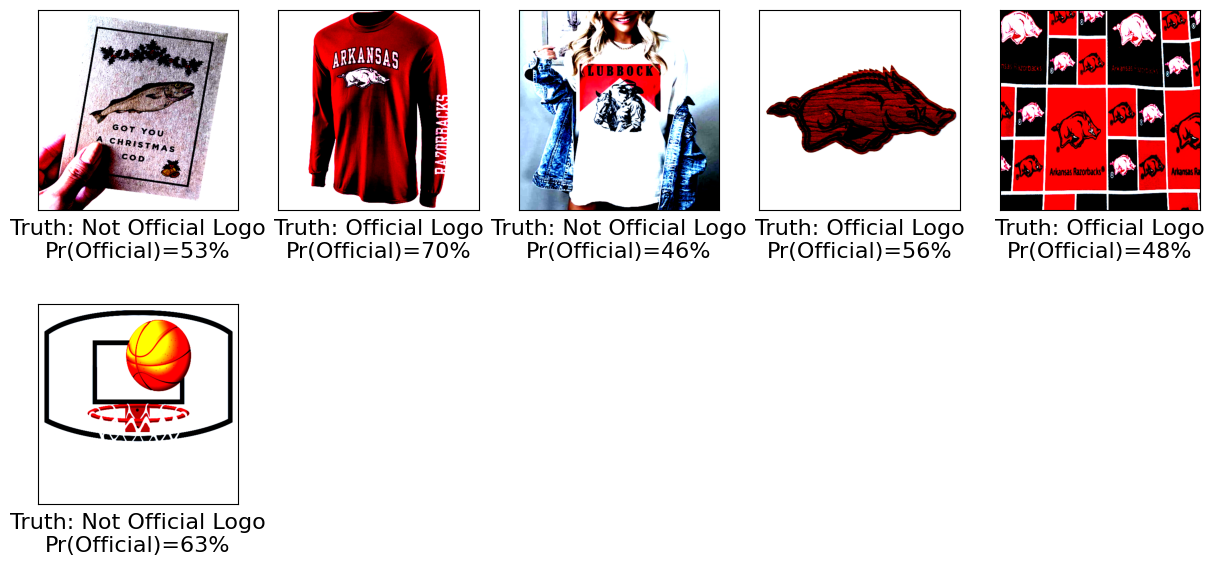

In [247]:
# =====================[ Visualize Input & Predicted Labels ]===================== #

# pred = model2(x_batch)[:, 0] * 100
pred = torch.sigmoid(model2(x_batch)[:, 0]) * 100

fig = plt.figure(figsize=(15, 7))
for j in range(min(10, x_batch.shape[0])):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Official Logo'
    else:
        label = 'Not Official Logo'
    ax.text(
        0.5, -0.15,
        f'Truth: {label:s}\nPr(Official)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()